In [1]:
import pickle 
import os
import torch
import os.path


In [2]:
# %run merge.py ./train_10M ./10MModel ./gradients ./influence

## Create New Curriculum

In [3]:
import pandas as  pd
import os
import torch
import numpy as np
# pd.DataFrame(a)

In [4]:
from datasets import load_dataset

In [5]:
import json

with open("./configs/curriculum_10M_2024") as f:
    config_curriculum = json.load(f)
    print(config_curriculum)
with open("./configs/random_10M_2024") as f:
    config = json.load(f)
    print(config)
import datasets
dataset = datasets.load_from_disk(config["dataset_folder"])

curriculum = torch.load(config["curriculum_path"])
config["influence_output_dir"] = os.path.join("./influence", os.path.basename(config["curriculum_path"]))
from pathlib import Path



{'dataset_folder': './curricula/datasets/curriculum_10M_2024', 'raw_dataset_folder_babylm': './train_10M', 'curriculum_path': './curricula/curriculum_10M_2024', 'eval_dataset_folder': './curricula/datasets/curriculum_10M_2024_eval', 'epochs_per_stage': 2, 'curriculum': {'C1': ['childes.train'], 'C2': ['open_subtitles.train', 'bnc_spoken.train'], 'C3': ['switchboard.train'], 'C4': ['gutenberg.train'], 'C5': ['simple_wiki.train']}, 'epoch_equivalents': 2.0, 'epochs': 10}
{'dataset_folder': './curricula/datasets/curriculum_10M_2024', 'raw_dataset_folder_babylm': './train_10M', 'curriculum_path': './curricula/random_10M_2024', 'eval_dataset_folder': './curricula/datasets/curriculum_10M_2024_eval', 'epochs': 10}


/tmp/ipykernel_1288809/3780737155.py:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  curriculum = torch.load(config["curriculum_path"])


In [6]:
df

NameError: name 'df' is not defined

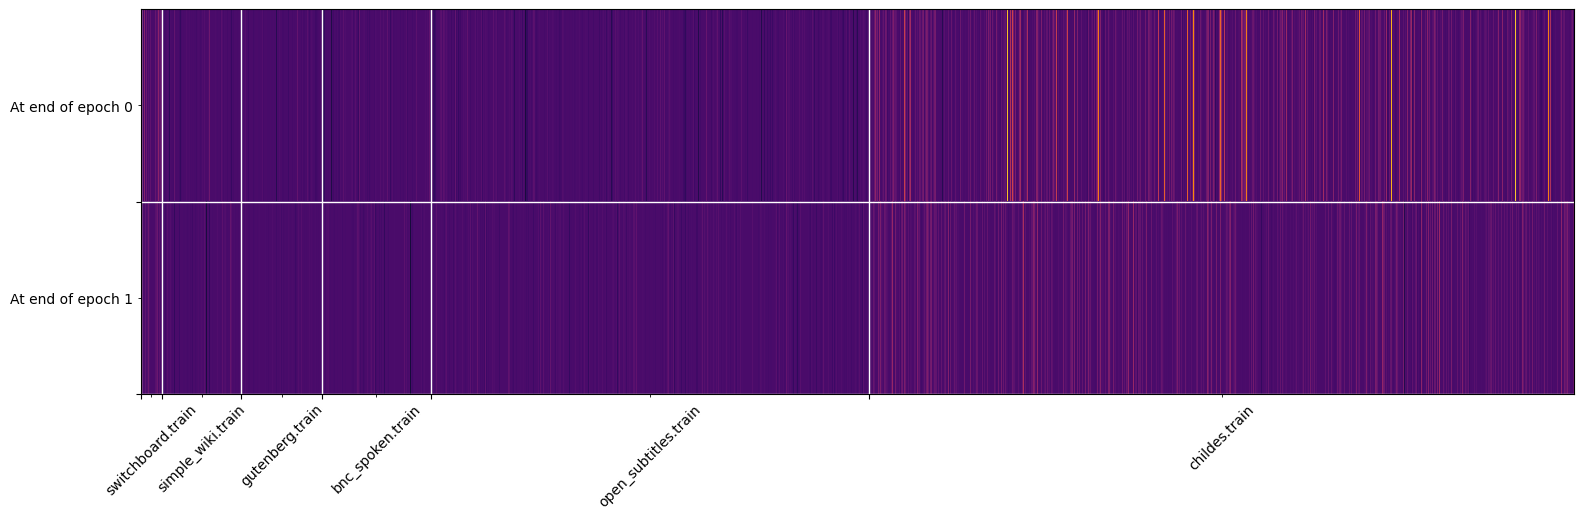

In [25]:

df = pd.DataFrame({int(result_checkpoint): torch.load(os.path.join(config["influence_output_dir"],result_checkpoint),weights_only=True,map_location="cpu").numpy().flatten() for result_checkpoint in os.listdir(config["influence_output_dir"])})
# df = df.rename({0: "influence"}, axis=1)
df.sort_index(axis=1)


df = df.reindex(sorted(df.columns, reverse=False), axis=1)
df = df.sample(frac=1)
df["total"] = df.sum(axis=1)
df[["text", "source"]] = dataset.to_pandas()
df["document_lenght"] = df["text"].str.split(r"\S+").str.len()

dff = df[list(df.columns[0:-4])+["source"]].sort_values(by="source")
vc = dff["source"].value_counts().sort_values(ascending=True)
counts = vc.to_numpy()
sources = vc.index.tolist()
ranges = [(start,stop) for start, stop in zip (np.cumsum(np.hstack((0,counts))),np.cumsum(counts))]
x_ticks,x_ticks_end = zip(*ranges)
out = np.empty((len(df.columns[0:-4]), len(df)))
for i, (source, (start,stop)) in enumerate(zip(sources, ranges)):
    # print(source, start, stop)
    # display(df[df["source"] == source][df.columns[0:-4]].to_numpy().T.shape)
    out[:,start:stop] = df[df["source"] == source][df.columns[0:-4]].to_numpy().T#.reshape(1, len(df))
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(18.5, 5)
plt.imshow(out,aspect="auto",interpolation="none", cmap="inferno")
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)


ax.set_xticks(x_ticks, [], minor=False)
ax.set_xticks(np.array(x_ticks_end) - ((np.array(x_ticks_end)-np.array(x_ticks))/2)  , sources, minor=True, rotation=45)

ax.set_yticks(np.arange(0.5, len(df.columns[0:-4]), 1), [], minor=False)
ax.set_yticks(np.arange(0.0, len(df.columns[0:-4]), 1), ["At end of epoch {}".format(i) for i in np.arange(0, len(df.columns[0:-4]))], minor=True)
ax.grid(color='w', linestyle='-', linewidth=1)

# ax.get_yaxis().get_major_formatter().set_scientific(False)



In [9]:

# df = df.iloc[curriculum[0:2].flatten().unique().tolist()]
# display(df[df["text"].str.match(r'^\s*$')])
# df = df[~df["text"].str.match(r'^\s*$')]
# df = df[df["document_lenght"] > 3] # TODO
# df

,9212,18424,27636,36848,46060,55272,64484,73696,82908,92120,total,text,source,document_lenght
175952,0.013200,0.000000,0.068245,0.002944,0.000000,0.000000,-0.005225,0.063996,0.000319,0.018002,0.161480,*MOT:\twe've got lots of Christmas cards haven...,childes.train,10
560903,0.108125,0.053902,0.000000,0.045409,0.000402,0.048472,0.027293,0.081555,-0.001532,0.152810,0.516436,*MOT:\tthere's a little bit left.,childes.train,7
601727,0.012173,0.006259,0.001428,-0.000056,0.001436,-0.002775,0.000613,0.001387,-0.001587,-0.007947,0.010931,What do I have to do to get a straight answer ...,open_subtitles.train,15
16513,0.000000,0.261965,0.080964,0.000000,0.001767,0.068730,0.046959,0.000000,0.000000,0.000000,0.460386,*COL:\tRick whose spoon is this?,childes.train,7
811325,0.005570,-0.010141,0.001181,0.006389,0.020875,-0.000392,0.003997,-0.001961,0.006279,0.009947,0.041744,"HEY, YOU.",open_subtitles.train,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1073347,0.004532,-0.004567,0.000746,-0.002518,0.000000,-0.000375,0.000713,0.000233,-0.000333,0.000012,-0.001558,"Ben, who had grown tired of waiting for his au...",gutenberg.train,111
1068632,0.002211,-0.000113,-0.000895,-0.000246,0.002704,-0.001132,-0.001931,0.001981,0.004111,0.001459,0.008149,For a moment the great brute seemed as much su...,gutenberg.train,24
1152251,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,,simple_wiki.train,1
983572,0.038174,-0.023285,0.000000,0.000000,0.004149,0.008513,0.000000,-0.000680,0.000000,0.004826,0.031696,Then give it to you.,open_subtitles.train,6


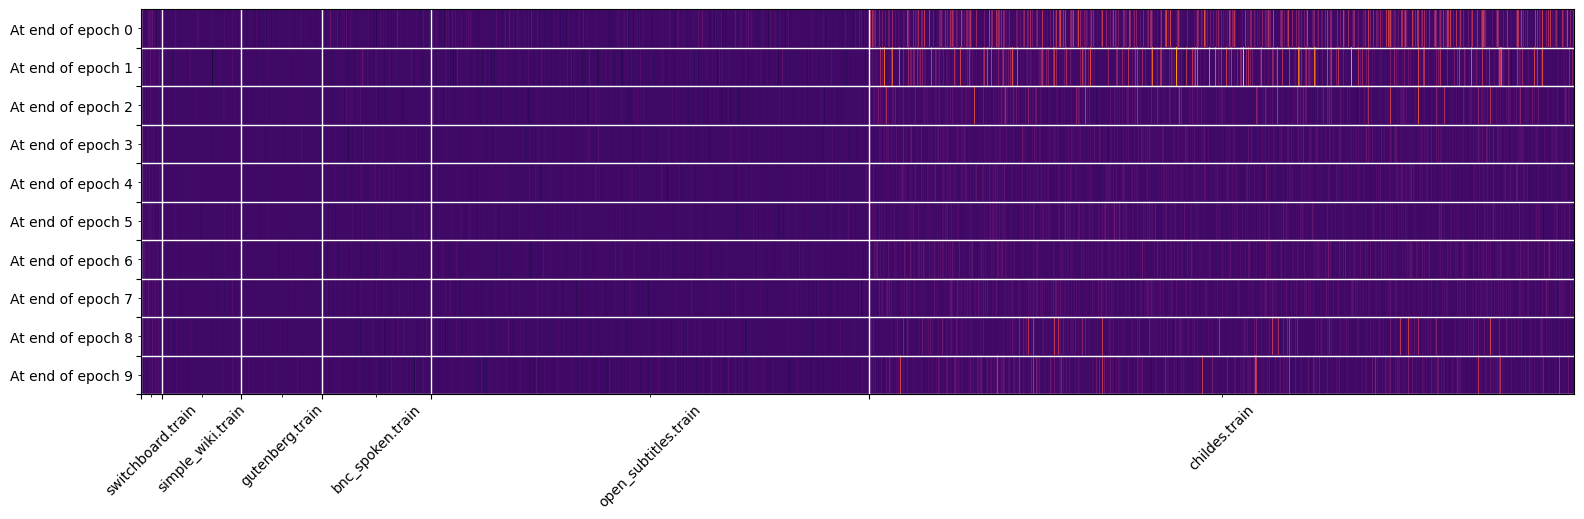

In [22]:

df = pd.DataFrame({int(result_checkpoint): torch.load(os.path.join(config["influence_output_dir"],result_checkpoint),weights_only=True,map_location="cpu").numpy().flatten() for result_checkpoint in os.listdir(config["influence_output_dir"])})
# df = df.rename({0: "influence"}, axis=1)
df.sort_index(axis=1)


df = df.reindex(sorted(df.columns, reverse=False), axis=1)
df = df.sample(frac=1)
df["total"] = df.sum(axis=1)
df[["text", "source"]] = dataset.to_pandas()
df["document_lenght"] = df["text"].str.split(r"\S+").str.len()

dff = df[list(df.columns[0:-4])+["source"]].sort_values(by="source")
vc = dff["source"].value_counts().sort_values(ascending=True)
counts = vc.to_numpy()
sources = vc.index.tolist()
ranges = [(start,stop) for start, stop in zip (np.cumsum(np.hstack((0,counts))),np.cumsum(counts))]
x_ticks,x_ticks_end = zip(*ranges)
out = np.empty((len(df.columns[0:-4]), len(df)))
for i, (source, (start,stop)) in enumerate(zip(sources, ranges)):
    # print(source, start, stop)
    # display(df[df["source"] == source][df.columns[0:-4]].to_numpy().T.shape)
    out[:,start:stop] = df[df["source"] == source][df.columns[0:-4]].to_numpy().T#.reshape(1, len(df))
import matplotlib.pyplot as plt

fig = plt.gcf()
fig.set_size_inches(18.5, 5)
plt.imshow(out,aspect="auto",interpolation="none", cmap="inferno")
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)


ax.set_xticks(x_ticks, [], minor=False)
ax.set_xticks(np.array(x_ticks_end) - ((np.array(x_ticks_end)-np.array(x_ticks))/2)  , sources, minor=True, rotation=45)

ax.set_yticks(np.arange(0.5, len(df.columns[0:-4]), 1), [], minor=False)
ax.set_yticks(np.arange(0.0, len(df.columns[0:-4]), 1), ["At end of epoch {}".format(i) for i in np.arange(0, len(df.columns[0:-4]))], minor=True)
ax.grid(color='w', linestyle='-', linewidth=1)

# ax.get_yaxis().get_major_formatter().set_scientific(False)



### But why?
- Is child directed speech actually more influential, just more difficult to learn, or most useful for learning the rest of the dataset?
    - Experiment: Add a proportion of random tokens?

In [168]:
import matplotlib.pyplot as plt
plt.imshow(s.to_numpy().T,aspect="auto",interpolation="none")
ax = plt.gca()
ax.get_xaxis().get_major_formatter().set_scientific(False)
ax.set_xticks([], [])
ax.set_yticks(np.arange(0.5, len(df.columns[0:-4]), 1))
ax.grid(color='w', linestyle='-', linewidth=1)

ax.get_yaxis().get_major_formatter().set_scientific(False)

AttributeError: 'numpy.ndarray' object has no attribute 'to_numpy'

(0.0, 250.0)

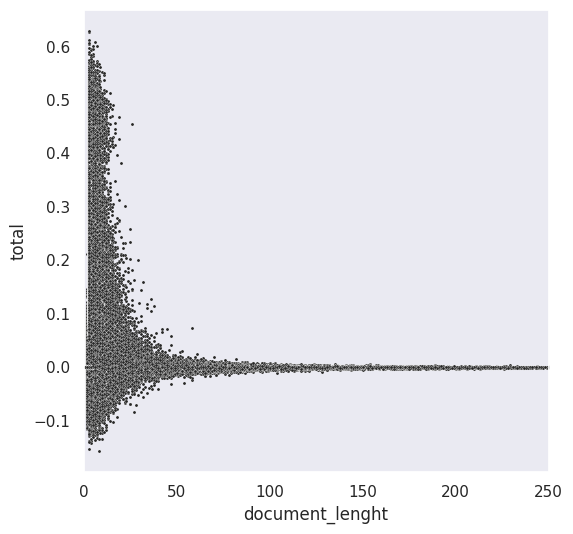

In [27]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="dark")

# Simulate data from a bivariate Gaussian

x, y =df["document_lenght"],df["total"]

# Draw a combo histogram and scatterplot with density contours
f, ax = plt.subplots(figsize=(6, 6))
sns.scatterplot(x=x, y=y, s=5, color=".15")
# sns.histplot(x=x, y=y, bins=50, pthresh=.1, cmap="mako")
ax.set_xlim(0,250)
# sns.kdeplot(x=x, y=y, levels=5, color="w", linewidths=1)

In [28]:
import scipy.stats as stats
stats.pearsonr(df["total"],df["document_lenght"],alternative="two-sided")

PearsonRResult(statistic=-0.11419504029072018, pvalue=0.0)

In [33]:
len(df.columns[0:-4])

2

In [34]:
df.columns[0:-4]

Index([7344, 8188], dtype='object')

In [29]:
NUM_DOCS_STAGE = len(df) // NUM_STAGES
NUM_DOCS_STAGE

NameError: name 'NUM_STAGES' is not defined

In [26]:
config

{'dataset_folder': './curricula/datasets/curriculum_10M_2024',
 'raw_dataset_folder_babylm': './train_10M',
 'curriculum_path': './curricula/random_10M_2024',
 'eval_dataset_folder': './curricula/datasets/curriculum_10M_2024_eval',
 'epochs': 10}

{'dataset_folder': './curricula/datasets/curriculum_10M_2024', 'raw_dataset_folder_babylm': './train_10M', 'curriculum_path': './curricula/curriculum_10M_2024', 'eval_dataset_folder': './curricula/datasets/curriculum_10M_2024_eval', 'epochs_per_stage': 2, 'curriculum': {'C1': ['childes.train'], 'C2': ['open_subtitles.train', 'bnc_spoken.train'], 'C3': ['switchboard.train'], 'C4': ['gutenberg.train'], 'C5': ['simple_wiki.train']}, 'epoch_equivalents': 2.0, 'epochs': 10}
{'dataset_folder': './curricula/datasets/curriculum_10M_2024', 'raw_dataset_folder_babylm': './train_10M', 'curriculum_path': './curricula/random_10M_2024', 'eval_dataset_folder': './curricula/datasets/curriculum_10M_2024_eval', 'epochs': 10}


{'dataset_folder': './curricula/datasets/curriculum_10M_2024', 'raw_dataset_folder_babylm': './train_10M', 'curriculum_path': './curricula/random_10M_2024', 'eval_dataset_folder': './curricula/datasets/curriculum_10M_2024_eval', 'epochs': 10}


,9212,18424,27636,36848,46060,55272,64484,73696,82908,92120,total,text,source,document_lenght
0,0.000000,0.196915,0.464265,0.168282,0.054872,0.023046,0.051617,0.032035,0.015906,0.008399,1.015337,*CHI:\twhat's that?,childes.train,4
1,0.215043,0.052703,0.130161,0.045186,0.015314,0.025799,0.008130,-0.002933,0.086384,0.044641,0.620429,*MOT:\tyeah.,childes.train,3
2,0.130555,0.031752,0.398065,0.113166,0.084688,0.072645,0.047322,0.034912,0.011752,0.005345,0.930202,*CHI:\txxx that.,childes.train,4
3,-0.000313,0.001169,0.000973,0.000264,0.029773,0.007767,0.044175,0.013503,0.004643,0.006240,0.108195,*CHI:\tyes.,childes.train,3
4,0.002561,0.122183,0.139494,0.037030,0.055496,0.016643,0.027887,0.010327,0.008796,0.119937,0.540355,*CHI:\t[babbles].,childes.train,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179009,0.011064,-0.028697,-0.005899,-0.017692,-0.005494,-0.000605,-0.001288,-0.000507,-0.000258,-0.000148,-0.049523,Gate of China is one of the Gates of old China...,simple_wiki.train,112
1179010,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.002727,-0.001382,-0.000334,-0.004443,Kivitoo was a Distant Early Warning Line site....,simple_wiki.train,99
1179011,0.000385,0.001423,0.000343,-0.000568,0.000187,-0.000054,0.000143,0.010581,0.008184,0.010588,0.031212,= = = Saint-Poix = = =,simple_wiki.train,8
1179012,-0.001100,0.107309,0.023218,0.009043,-0.000616,0.000789,0.000879,0.000590,0.000725,0.003571,0.144407,Bretzwil is a municipality of the district of ...,simple_wiki.train,17


tensor([[229095, 227789, 176060,  ..., 965463, 529224, 964686],
        [485538, 484395, 440928,  ..., 447519, 137239, 234713],
        [  6786,   2124,   2148,  ..., 612135,  82712, 252852],
        ...,
        [ 78195,  83997,  97516,  ..., 822717,  30183, 674626],
        [106197,   5589, 106599,  ..., 997661,   4947, 642755],
        [   245, 259288, 103373,  ..., 830075, 862666, 863557]])

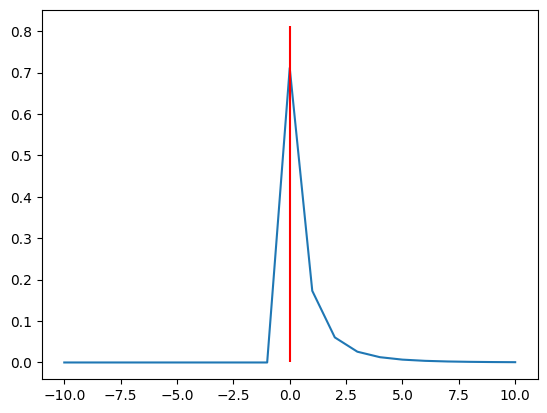

In [1]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import norm
from scipy.stats import f
from scipy.stats import lognorm


import json
import os
import pandas as pd
import torch
import datasets
from datasets import load_dataset



def gaussian_filter(size, **args):
    indices = np.arange(-size, size+1, 1)
    weights =  norm.pdf(indices, **args)
    return weights# / np.sum(weights)


def f_filter(size, **args):
    indices = np.arange(-size, size+1, 1)
    print(indices)
    weights = f.pdf(indices+1, **args)
    return weights# / np.sum(weights)
def lognorm_filter(size, **args):
    #print(args)
    indices = np.arange(-size, size+1, 1)
    #print(indices)
    weights = lognorm.pdf(indices+1, **args)
    return weights / np.sum(weights)



with open("./configs/random_10M_2024") as f:
    config = json.load(f)
    print(config)
config["influence_output_dir"] = os.path.join("./influence", os.path.basename(config["curriculum_path"]))
dataset = datasets.load_from_disk(config["dataset_folder"])
df = pd.DataFrame({int(result_checkpoint): torch.load(os.path.join(config["influence_output_dir"],result_checkpoint),weights_only=True,map_location="cpu").numpy().flatten() for result_checkpoint in os.listdir(config["influence_output_dir"])})
df.sort_index(axis=1)

df = df.reindex(sorted(df.columns, reverse=False), axis=1)
influence_cols = df.columns
df["total"] = df.sum(axis=1)
df[["text", "source"]] = dataset.to_pandas()
df["document_lenght"] = df["text"].str.split(r"\S+").str.len()




def reweight_df(df, influence_cols, filter_weights):
    scores = pd.DataFrame(np.apply_along_axis(lambda m: np.convolve(m,filter_weights, mode="valid")[1:-1], axis=1, arr=df[influence_cols].to_numpy()))
    scores.columns = influence_cols
    df_reweighted = df.copy()
    df_reweighted[influence_cols] = scores
    df_reweighted["total"] = df_reweighted[influence_cols].sum(axis=1)
    return df_reweighted



filter_weights = lognorm_filter(len(influence_cols), s=1, loc=0, scale=0.5)
plt.plot(np.arange(-len(influence_cols),len(influence_cols)+1, 1),filter_weights)
plt.vlines([0], ymin=0, ymax=max(filter_weights)+0.1, colors=["red"])
df_reweighted = reweight_df(df, influence_cols, lognorm_filter(len(influence_cols), s=1, loc=0, scale=0.5))
display(df_reweighted)


torch.stack([torch.tensor(df[checkpoint].sort_values(ascending=False).index.to_numpy()) for checkpoint in influence_cols])

,9212,18424,27636,36848,46060,55272,64484,73696,82908,92120,total,text,source,document_lenght
0,0.000000,0.196915,0.464265,0.168282,0.054872,0.023046,0.051617,0.032035,0.015906,0.008399,1.015337,*CHI:\twhat's that?,childes.train,4
1,0.215043,0.052703,0.130161,0.045186,0.015314,0.025799,0.008130,-0.002933,0.086384,0.044641,0.620429,*MOT:\tyeah.,childes.train,3
2,0.130555,0.031752,0.398065,0.113166,0.084688,0.072645,0.047322,0.034912,0.011752,0.005345,0.930202,*CHI:\txxx that.,childes.train,4
3,-0.000313,0.001169,0.000973,0.000264,0.029773,0.007767,0.044175,0.013503,0.004643,0.006240,0.108195,*CHI:\tyes.,childes.train,3
4,0.002561,0.122183,0.139494,0.037030,0.055496,0.016643,0.027887,0.010327,0.008796,0.119937,0.540355,*CHI:\t[babbles].,childes.train,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1179009,0.011064,-0.028697,-0.005899,-0.017692,-0.005494,-0.000605,-0.001288,-0.000507,-0.000258,-0.000148,-0.049523,Gate of China is one of the Gates of old China...,simple_wiki.train,112
1179010,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.002727,-0.001382,-0.000334,-0.004443,Kivitoo was a Distant Early Warning Line site....,simple_wiki.train,99
1179011,0.000385,0.001423,0.000343,-0.000568,0.000187,-0.000054,0.000143,0.010581,0.008184,0.010588,0.031212,= = = Saint-Poix = = =,simple_wiki.train,8
1179012,-0.001100,0.107309,0.023218,0.009043,-0.000616,0.000789,0.000879,0.000590,0.000725,0.003571,0.144407,Bretzwil is a municipality of the district of ...,simple_wiki.train,17


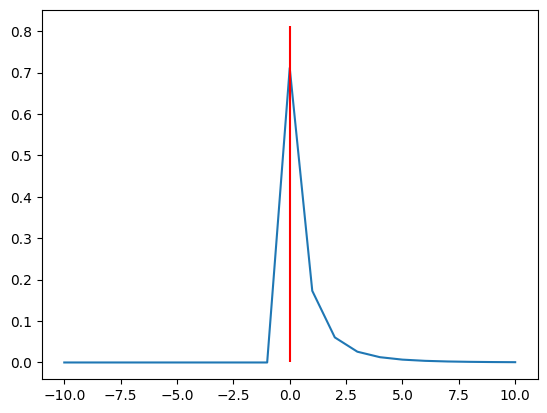

tensor([[229095, 227789, 176060,  ..., 965463, 529224, 964686],
        [485538, 484395, 440928,  ..., 447519, 137239, 234713],
        [  6786,   2124,   2148,  ..., 612135,  82712, 252852],
        ...,
        [ 78195,  83997,  97516,  ..., 822717,  30183, 674626],
        [106197,   5589, 106599,  ..., 997661,   4947, 642755],
        [   245, 259288, 103373,  ..., 830075, 862666, 863557]])

torch.Size([10, 1179014])

In [64]:
config

{'dataset_folder': './curricula/datasets/curriculum_10M_2024',
 'raw_dataset_folder_babylm': './train_10M',
 'curriculum_path': './curricula/random_10M_2024',
 'eval_dataset_folder': './curricula/datasets/curriculum_10M_2024_eval',
 'epochs': 10,
 'influence_output_dir': './influence/random_10M_2024'}

In [22]:

df_usefulness_ = df_usefulness.copy()
for stage in STAGES:
    pd.concat([df_usefulness_,df_usefulness.sort_values(by=STAGES[1], ascending=False)]).drop_duplicates(keep="first")[0:2*NUM_DOCS_STAGE]

In [54]:
df

,9212,18424,27636,36848,46060,55272,64484,73696,82908,92120
0,0.000000,0.276882,0.585464,0.070661,0.000000,0.000000,0.056808,0.022754,0.007101,0.003080
1,0.302373,0.000566,0.157141,0.014208,-0.000748,0.026565,0.000000,-0.009165,0.121064,0.032589
2,0.183574,0.000000,0.544093,0.020077,0.064583,0.063050,0.034181,0.026801,0.000000,0.000000
3,-0.000440,0.001751,0.000980,0.000000,0.041724,0.000711,0.058358,0.003189,0.000000,0.005945
4,0.003602,0.170926,0.154266,-0.000134,0.058615,0.000411,0.029686,0.002665,0.006676,0.164233
...,...,...,...,...,...,...,...,...,...,...
1179009,0.015557,-0.044135,0.001115,-0.021959,-0.001144,0.001898,-0.001051,0.000000,0.000000,0.000000
1179010,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.003834,-0.001011,0.000102
1179011,0.000541,0.001869,-0.000019,-0.000973,0.000423,-0.000134,0.000212,0.014828,0.007883,0.011699
1179012,-0.001547,0.151263,-0.004011,0.000870,-0.006243,0.000000,0.000354,0.000156,0.000566,0.004600


In [56]:
np.apply_along_axis(lambda m: np.convolve(m,filter_weights, mode="valid")[1:-1], axis=1, arr=n).shape

(1179014, 10)

In [57]:
df_usefulness = df.copy()
df_usefulness = np.apply_along_axis(lambda m: np.convolve(m,filter_weights, mode="valid")[1:-1], axis=1, arr=n)
df_usefulness

array([[ 0.00000000e+00,  1.96914862e-01,  4.64265216e-01, ...,
         3.20352912e-02,  1.59059160e-02,  8.39873567e-03],
       [ 2.15043361e-01,  5.27034299e-02,  1.30161052e-01, ...,
        -2.93329658e-03,  8.63843409e-02,  4.46413088e-02],
       [ 1.30555464e-01,  3.17524996e-02,  3.98064996e-01, ...,
         3.49120174e-02,  1.17515093e-02,  5.34454190e-03],
       ...,
       [ 3.84707467e-04,  1.42290044e-03,  3.42665514e-04, ...,
         1.05813177e-02,  8.18435710e-03,  1.05878722e-02],
       [-1.10000952e-03,  1.07308607e-01,  2.32175235e-02, ...,
         5.90372431e-04,  7.25185926e-04,  3.57065817e-03],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00]])

### With convolution

In [53]:
df_usefulness_ = df_usefulness.copy()
dfs_selection = []
for stage in df.columns:
    dfs_selection.append(df_usefulness_.nlargest(NUM_DOCS_STAGE, columns=stage))
    df_usefulness_ = df_usefulness_.nsmallest(len(df_usefulness_) - NUM_DOCS_STAGE, columns=stage)
 
# print(len(df_usefulness_))
# result = []
# for stage_id, d in enumerate(dfs_selection):
#     print(os.path.join(args["curriculum_output_folder"],"{}.train".format(stage_id)))
#     with open(os.path.join(args["curriculum_output_folder"],"{}.train".format(stage_id)), "w") as f:
#         for line in d["text"]:
#             f.write(line + "\n") 
#     display(d)
#     result.append(d)

# d = pd.concat(result)
# import matplotlib.pyplot as plt
# plt.imshow(d[d.columns[0:-4]].to_numpy().T,aspect="auto",interpolation="none")
# ax = plt.gca()
# ax.get_xaxis().get_major_formatter().set_scientific(False)
# ax.set_xticks([], [])
# ax.set_yticks(np.arange(0.5, len(df.columns[0:-4]), 1))
# ax.grid(color='w', linestyle='-', linewidth=1)

# ax.get_yaxis().get_major_formatter().set_scientific(False)
# plt.show()




NameError: name 'STAGES' is not defined

In [55]:
from datasets import load_dataset
dataset_c = load_dataset("text", data_dir=args["curriculum_output_folder"])

In [56]:
# assert all([t in dataset["text"] for t in dataset_c["text"]])

In [57]:
dataset_c[0]["text"] in dataset["text"]

### No convolution

In [58]:
df_usefulness_ = df.copy()
dfs_selection = []
for stage in STAGES:
    dfs_selection.append(df_usefulness_.nlargest(NUM_DOCS_STAGE, columns=stage))
    df_usefulness_ = df_usefulness_.nsmallest(len(df_usefulness_) - NUM_DOCS_STAGE, columns=stage)
    print(len(df_usefulness_))
print(len(df_usefulness_))
for a in dfs_selection:
    display(a)

In [59]:
df_usefulness